## In this notebook, we'll try analyzing Jon's data of beads in active networks using methods described in this [Cho et al 2020 PRL paper](https://link.aps.org/doi/10.1103/PhysRevLett.124.088005) and this [Wilson et al 2011 PRL paper](https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.106.018101)

### From the Cho paper, we'll get A, B and add the non-ergodicity parameter, c
With DDM, we take a movie and generate the DDM matrix, $D(q,\Delta t)$ (the generation of this DDM matrix should already have been done before going through this code). This can be fit to the function:
$D(q,\Delta t) = A(q)(1 - f(q,\Delta t)) + B(q)$. 
The function $f(q,\Delta t)$ is called the intermediate scattering function (ISF). And we usually assume it has the form: $f(q,\Delta t) = \mbox{exp}(-\Delta t / \tau (q))^{\alpha (q)}$ where $\alpha (q)$ is the stretching exponent and $\tau (q)$ is the characteristic decay time.

What we have usually tried is to take $D(q,\Delta t)$ and, for each wave vector $q$, fit it to find the parameters $A, B, \tau, \text{ and } \alpha$.

What we do now (using the methods of [Cho et al](https://link.aps.org/doi/10.1103/PhysRevLett.124.088005)) is get the parameters $A$ and $B$ from the images themselves. Then we can get the ISF: $f(q,\Delta t) = 1 - \frac{D(q,\Delta t) - B(q)}{A(q)}.$ 

We also add a new paramter to the ISF: the non-ergodicity parameter, $C$. So now we have that the ISF is equal to: $f(q,\Delta t) = (1-C(q))\mbox{exp}(-\Delta t / \tau (q))^{\alpha (q)} + C(q)$. If $C$ is zero, then this ISF is just $\mbox{exp}(-\Delta t / \tau (q))^{\alpha (q)}$, as we had before. And that's the expected case for ergodic dynamics. But if the system is non-ergodic, then we expect a non-zero $C$, somewhere between 0 and 1. 

Note that in this code, we refer to $D(q, \Delta t)$ as 'ravs'. That is because getting $D(q, \Delta t)$ involves finding the <b>r</b>adial <b>av</b>erages of a matrix.

### From the Wilson paper, we'll add a velocity distribution to $f(q,\Delta t)$

I need to add this part...

In [165]:
%matplotlib notebook
from timeit import default_timer as timer
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

font_plt = {'family': 'serif','color':  'darkred','weight': 'normal','size': 8,}
font_plt_ax = {'family': 'serif','color':  'black','weight': 'normal', 'size': 8,}

import numpy as np #numerical python used for working with arrays, mathematical operations
import time #useful for timing functions
import sys
import os
import csv
import glob #glob is helpful for searching for filenames or directories
import ddm_clean as ddm #this is the module containing the differential dynamic microscopy code
import scipy #scientific python
from scipy.signal import blackmanharris as bh #for Blackman-Harris windowing
from scipy.optimize import least_squares
import pickle #for saving data

In [2]:
reload(ddm) #reload of ddm necessary if changes have been made

<module 'ddm_clean' from 'ddm_clean.pyc'>

## Movie number and ROI specified below

In [193]:
#######################################################################################
#Specify where the data is stored and the image data filename. Must be in tiff format
#######################################################################################

########################
# Select Movie Number  #
movie_num = 1
########################
date= '2020-07-29'
#######################
condition="Actin_myosin"
#condition="AMT_myosin"
#condition="100M_myosin"
#condition="75A25M"
#condition="25A75M"
########### Select ROI here ###############
ROI = 256  # <---- select ROI (0,256,512, or 768)
###########################################

data_dir = "Y:\\Jon_Garamella\\data\\active_networks\\videos_date\\%s\\%s\\20200729_Actin_0237myosin_STIM405_488OD6_50msEXPO_20fps_%i\\" % (date,condition,movie_num)
data_file = "20200729_Actin_0237myosin_STIM405_488OD6_50msEXPO_20fps_%i_MMStack_Pos0.ome.tif"%movie_num

## Below, we load in the images. If this step was already done and you can read in the pickle file containing the necessary data, don't bother rerunning this.

tiff_file.py:725: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for p in pages)


<IPython.core.display.Javascript object>


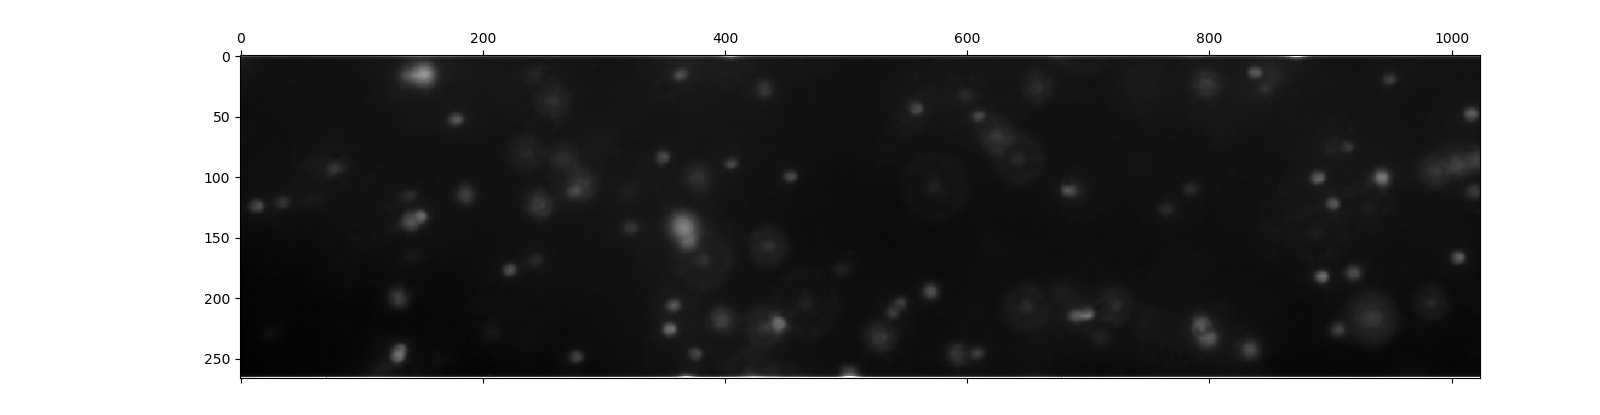

In [194]:
#Image read using tiff_file module
im = ddm.tiff_file.imread(data_dir+data_file)

#Display the second frame of the image
plt.matshow(im[1], cmap=matplotlib.cm.gray)

### Open up the previosly generated DDM matrix data

In [196]:
#######################################################################################
#  Specify where the DDM matrix data is stored
#######################################################################################
data_dir = "Y:\\Jon_Garamella\\data\\active_networks\\videos_date\\%s\\%s\\ddm_analysis\\405stim\\" %(date,condition)
data_file = "20200729_Actin_0237myosin_STIM405_488OD6_50msEXPO_20fps_%i_MMStack_Pos0.ome_%i_256x256_FFTDIFFS_dts_ravs.p" %(movie_num,ROI)

f = open(data_dir + data_file,'rb')
p_data = pickle.load(f)
f.close()
print("The 'keys' contained in this pickle'd dictionary are: ", p_data.keys())

("The 'keys' contained in this pickle'd dictionary are: ", ['dts', 'ravs', 'ffts'])


In [197]:
#copy over that data stored in the dictionary
ravs = p_data['ravs']
dts = p_data['dts']

In [198]:
##########################################################################
# Specify the frame rate (fps) and pixel size
##########################################################################

fps = 20.0 #The frame rate the video data was recorded at. 
times = dts/fps #Create the list of delay times in units of seconds
pixel_size = 0.194 #pixel size in microns
numPixels = 256 #number pof pixels in ROI
q = np.arange(0,numPixels/2)*2*np.pi*(1./(numPixels*pixel_size)) #Convert the spatial frequencies to wave vectors

<IPython.core.display.Javascript object>


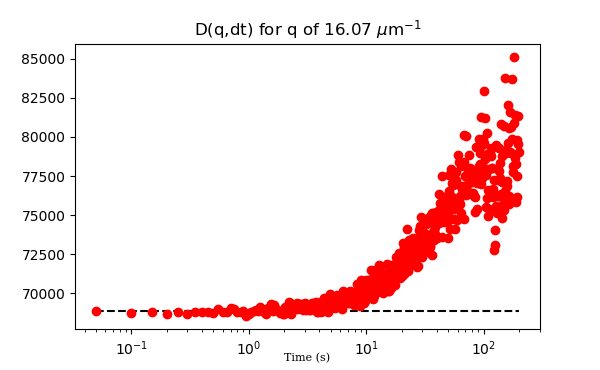

Horizontal line at 68866.6


In [199]:
# Here, we'll show the image structure function for a particular q-value. 

qv=-1 # <-- this is the last q-value. useful for getting estimate of background
fig = plt.figure(figsize=(6,6./1.618))
plt.semilogx(times, ravs[:,qv],'ro')
ax = plt.gca()
plt.xlabel('Time (s)', fontdict=font_plt_ax, labelpad=-3);
plt.title("D(q,dt) for q of %.2f $\mu$m$^{-1}$" % q[qv]);
plt.hlines(ravs[0,qv], times[0], times[-1], linestyles='dashed')
print("Horizontal line at %.1f" % ravs[0,qv])

At this step, we could try fitting $D(q, \Delta t)$ to the model described at the very beginning to determine $A$, $B$, $\tau$ and $\alpha$. If you want to do that, you'll find the code at the end of this notebook. But that step isn't necessary.

## New method for getting A and B



In [208]:
#Data file to store avg abs(fft)^2 which we need for getting A and B
#First, let us check whether this file already exists. If it does,
#we don't have to calculate it again
data_file = "%s%i_256X256_imageffts_for_AB.p" %(data_file[:-48],ROI) 

data_file_exists = os.path.isfile(data_dir + data_file)
if data_file_exists:
    print("Data file already exists.")
else:
    print("Data file does NOT exist.")

Data file already exists.


In [210]:
#This uses the variable 'ROI' which you should have set at the beginning (as 0, 256, 512, or 768)
ROI = 256

loc = 1 #0 is ROI 0, 1 is 256, 2 is 512, 3 is 768

if not data_file_exists:
    
    #these are the initial and final x and y coordinates for 
    #  the different ROIs
    xi=[5, 5, 5, 5]
    xf=[261, 261, 261, 261]
    yi=[0, 256, 512, 768]
    yf=[256, 512, 768, 1024]
    
    #Get the dimensions of the ROI'd image
    nframes, ndx, ndy = im[:,xi[loc]:xf[loc],yi[loc]:yf[loc]].shape
    print("Our image has %i frames and each frame is %i x %i pixels" % (nframes, ndx,ndy))

    #get the average abs(fft)^2 for each frame
    av_fftsq_of_each_frame = np.zeros_like(im[0,xi[loc]:xf[loc],yi[loc]:yf[loc]]*1.0) #initialize array
    for i in range(0, nframes):
        #looping over all frames in the movie
        fft_of_image = np.fft.fft2(im[i,xi[loc]:xf[loc],yi[loc]:yf[loc]]*1.0)
        sqr_of_fft = np.fft.fftshift(fft_of_image*np.conj(fft_of_image))
        av_fftsq_of_each_frame = av_fftsq_of_each_frame + abs(sqr_of_fft)
    av_fftsq_of_each_frame = av_fftsq_of_each_frame/(1.0*nframes*ndx*ndy)
    
    #get radially average
    rad_av_av_fftsq = ddm.radialAvFFTs_v2(av_fftsq_of_each_frame.reshape(1,ndx,ndy))

    data_file = "%s%i_256X256_imageffts_for_AB.p" %(data_file[:-48],ROI)
    f = open(data_dir + data_file,'wb')
    pickle.dump({'rad_av_av_fftsq': rad_av_av_fftsq}, f)
    f.close()
    
else:
    f = open(data_dir + data_file,'rb')
    p_data = pickle.load(f)
    f.close()
    rad_av_av_fftsq = p_data['rad_av_av_fftsq']

In [211]:
if not data_file_exists:    
    #here we just show the fourier transformed image, if we had to calculate it
    plt.figure()
    plt.matshow(np.log(av_fftsq_of_each_frame),fignum=0)
else:
    print("The 2D array of the avg ft(I)^2 not saved, just the radial average.")

The 2D array of the avg ft(I)^2 not saved, just the radial average.


<IPython.core.display.Javascript object>


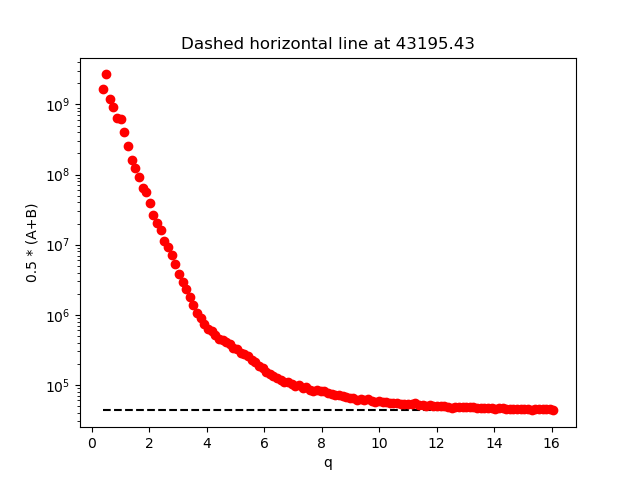

Text(0.5,1,'Dashed horizontal line at 43195.43')

In [212]:
plt.figure()
plt.semilogy(q[3:], rad_av_av_fftsq[0,2:],'ro')
plt.xlabel("q")
plt.ylabel("0.5 * (A+B)")
plt.hlines(rad_av_av_fftsq[0,-1], q[3], q[-1], linestyles='dashed')
plt.title("Dashed horizontal line at %.2f" % rad_av_av_fftsq[0,-1])

Based off of the DDM data, I'd say the background is ~ 40 (in many cases, depends on video). 
Based off the above plot, seems like it (1/2)(A+B) is plateauing at high q to around ??. So B is around twice that. 

In [213]:
############################################################
#You can play around with this 'background' parameter, 
#but I usually use the flat line from the plot above where
#we plot the highest q value (reminder below)
#qv=-1 # <-- this is the last q-value. useful for getting estimate of background
#fig = plt.figure(figsize=(6,6./1.618))
#plt.semilogx(times, ravs[:,qv],'ro')
############################################################
background = 68500
new_amplitude = (2*rad_av_av_fftsq[0]) - background

<IPython.core.display.Javascript object>


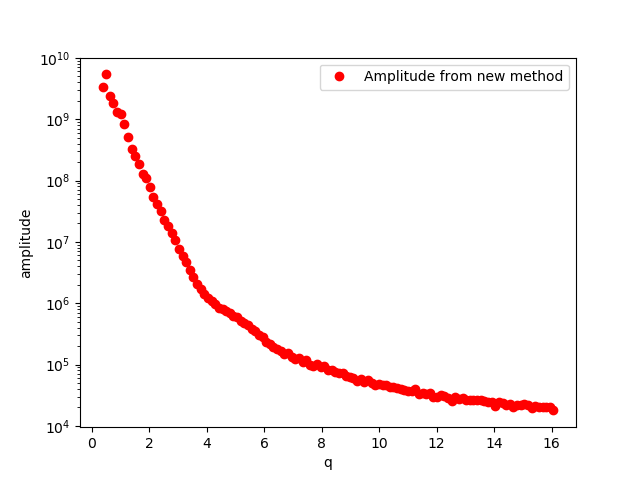

'amp' not defined


In [214]:
plt.figure()
plt.semilogy(q[3:], new_amplitude[2:], 'ro', label='Amplitude from new method')
try: plt.plot(q[3:], amp[2:], 'mo', label='Amplitude from fitting method')
except: print("'amp' not defined")
plt.xlabel("q")
plt.ylabel("amplitude")
plt.legend(loc=0)

Based on our new value for amplitude, let's find the intermediate scattering function

In [215]:
#Just double checking sizes of arrays:
print("size of ravs array (the ddm matrix or image struct func): %i by %i" % ravs.shape)
print("size of new amplitudes: %i" % new_amplitude.shape)

size of ravs array (the ddm matrix or image struct func): 500 by 127
size of new amplitudes: 127


In [216]:
#Initialize arrays to store the ISF (intermediate scattering function)
isf = np.zeros_like(ravs) #decay time

for i in range(1,ravs.shape[1]):
    isf[:,i] = 1 - ((ravs[:,i] - background) / new_amplitude[i])

<IPython.core.display.Javascript object>


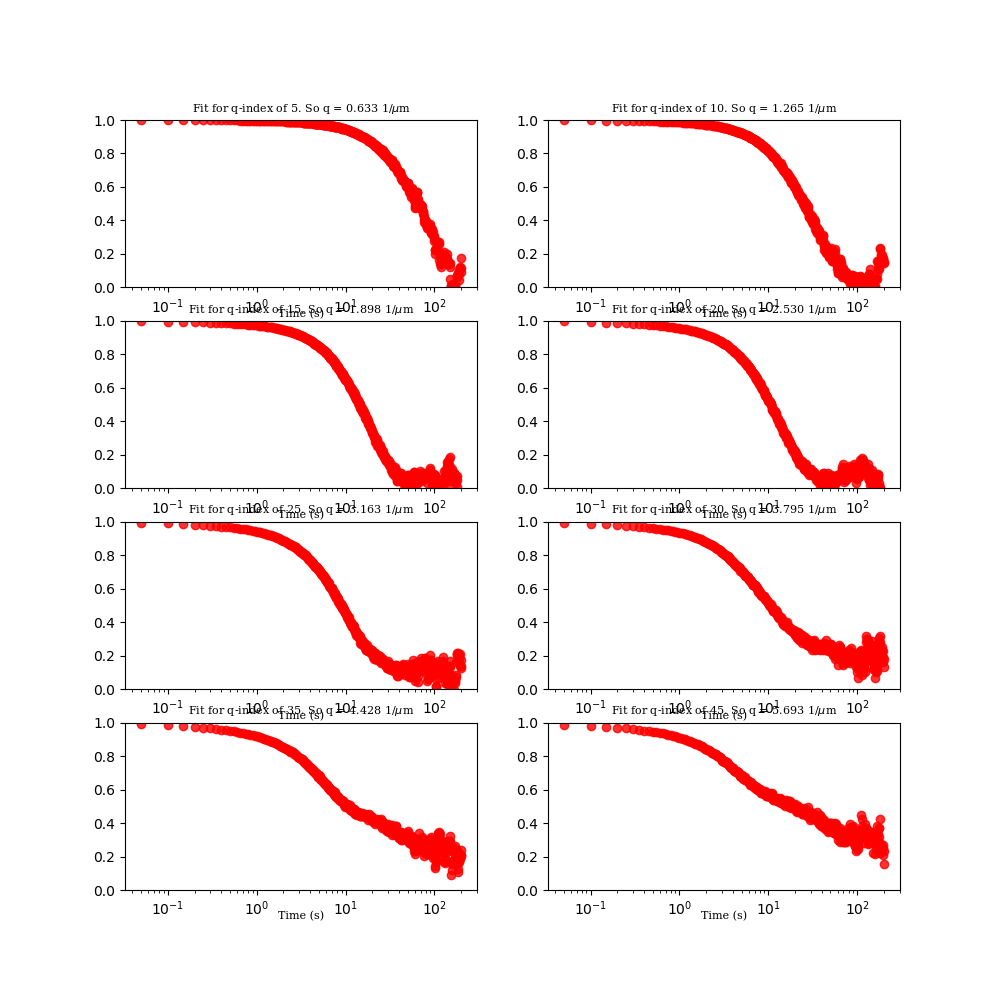

In [217]:
plt.figure(figsize=(10,10)) #Create figure of size 15x15 (inches)


#Loop over 8 different q-values to plot the ISF
for i,q_index in enumerate([5,10,15,20,25,30,35,45]):

    ax = plt.subplot(4,2,i+1) #creating 4 subplots in a 2x2 grid
    ax.semilogx(times,isf[:,q_index],'ro',alpha=0.8)
    
    ax.set_xlabel("Time (s)", fontdict=font_plt_ax, labelpad=-5)
    ax.set_title("Fit for q-index of %i. So q = %.3f 1/$\mu$m" % (q_index, q[q_index]), fontdict=font_plt_ax)
    
    ax.set_ylim(0,1)

### Defining the fitting function

The fitting function, `isf_fitting`, is described below. After running through this cell (and the next 3 or 4), you may need to come back to this point and re-run this function after you settle on a stretching exponent to use. You'll come back to the first uncommented-out line: <br>
`STRETCHING_EXP = 0.8` <br>
and set the value (which is the stretching exponent, $\alpha (q)$) to the correct value. 

In [221]:
##################################################################################################
# Stretching exponent.
# This number must be between 0 and 1. 
# And it will probably be around 0.8
# When you specify the value, don't go beyond hundredths place.
# Set this to the AVERAGE VALUE you find when you plot the set of 7 plots below

##################################################################################################

def errorfunc_for_scipy_leastsq_fit(params, data, times):
    theory = ddm.dTheoryTwoModeISF(times, params[0],params[1],params[2], params[3], params[4], params[5])
    return data-theory

def isf_fitting(data, times):
    '''
    This function does the ISF fitting. 

    We'll just use one round. Using the scipy least_squares module
    '''
    
    #Our parameters are: c (non-ergodicity param), t1 (diffusive), stretching exponent, t2 (ballistic), 
                        #a (proportion of those moving ballistically), Z
    pars = np.zeros(6)*1.0
    minp = np.zeros_like(pars)
    maxp = np.zeros_like(pars)
    lmin = np.array([True, True, True, True, True, True])
    lmax = np.array([True, True, True,True, True, True])
    fix = np.array([False, False, False,False, False, False])
    
    #come up with limits:
    minp[0] = 0.0 #minimum non-erg parameter
    maxp[0] = 1. #maximum non-erg parameter
    
    minp[1] = 0.01 #minimum diffusive decay time
    maxp[1] = 2000.0  #maximum diffusive decay time
    
    minp[2] = 0.3 #minimum stretching exponent
    maxp[2] = 1.0 #maximum stretching exponent
    
    minp[3] = 0.01 #minimum ballistic decay time
    maxp[3] = 2000.0 #maximum ballistic decay time
    
    minp[4] = 0.3 #minimum ballistic proportion
    maxp[4] = 1.0  #maximum ballistic proportion
    
    minp[5] = .1 #minimum Schulz Z
    maxp[5] = 30. #maximum Schulz Z
    
    #initial guesses and fixes
    pars[0] = 0.0 #non-ergodicity parameter
        
    pars[1] = 50.0 #decay time
    
    pars[2] = .8 #stretching exponent
    
    pars[3] = 2.0 #ballistic decay time 
    
    pars[4] = 0.8 #proportion of population
    
    pars[5] = 3.0 #schulz number
    
    # First step, use the Scipy Least Squares function to find best parameters
    fitparams_lstsq_temp = least_squares(errorfunc_for_scipy_leastsq_fit, pars, bounds=(minp,maxp), loss="linear",args=(data,times))
    fitparams_isf_lstsq = fitparams_lstsq_temp.x
    theory_isf_lstsq = ddm.dTheoryTwoModeISF(times, fitparams_isf_lstsq[0], fitparams_isf_lstsq[1], 
                                             fitparams_isf_lstsq[2],fitparams_isf_lstsq[3], fitparams_isf_lstsq[4], 
                                             fitparams_isf_lstsq[5])
    
    return fitparams_isf_lstsq, theory_isf_lstsq


In the next cell, we define the time lag that we end the fits at. We do this because the data for long time lags gets noisier. It also gets more noisy for high q at long times than low q at long times. So we make the last time we fit to a function of q. 

It is unclear if we will need this, but we'll leave it in for now and override it below.

In [222]:
last_times = np.linspace(300,2,num=len(q),dtype=np.int)

In this cell, we'll inspect some (8) of the fits to the ISF. Hopefully they look okay. Make a note if any of them look off. 

<IPython.core.display.Javascript object>


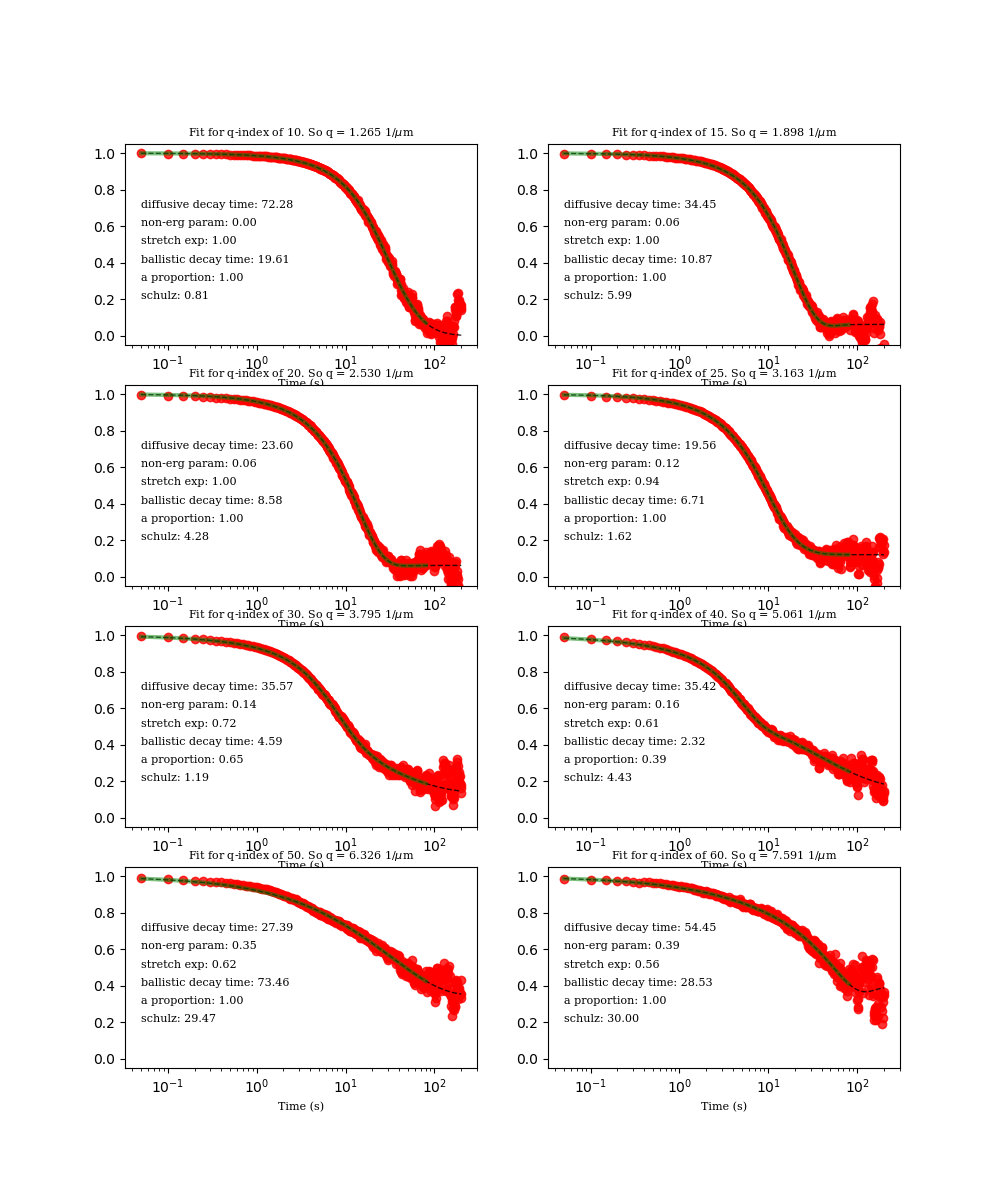

Saved as Y:\Jon_Garamella\data\active_networks\videos_date\2020-07-29\Actin_myosin\ddm_analysis\405stim\20200729_Actin_0237myosin_STIM405_488OD6_50msEXPO_20fps_1_256_256X256_ISF_fits.png


In [231]:
#########################################################################
# We don't have to fit all time lags. The long time lags may be noisy.
#########################################################################
# not implemented anymore: last_time = -350 # ONLY FIT UP TO THIS FINAL TIME POINT

plt.figure(figsize=(10,12)) #Create figure of size 10x12


#Loop over 8 different q-values to plot the ISF
for i,q_index in enumerate([10,15,20,25,30,40,50,60]):
    
    last_times = np.linspace(450,2,num=len(q),dtype=np.int)
    last_time = last_times[q_index]
    #Here is where we override the variable end time fit, as noted above
    last_time = 400
    
    fp_isf_lstsq, theory_isf_lstsq = isf_fitting(isf[:last_time,q_index],times[:last_time])
    full_time_theory = ddm.dTheoryTwoModeISF(times, *fp_isf_lstsq)

    ax = plt.subplot(4,2,i+1) #creating 4 subplots in a 2x2 grid
    ax.semilogx(times[:],isf[:,q_index],'ro',alpha=0.8)
    #ax.plot(times[:last_time], theory_isf, '-b',lw=3,alpha=0.5) #BLUE LINE: Leven-Marq fitting method
    ax.plot(times, full_time_theory, '--k',lw=1,alpha=0.8) #BLUE LINE: Leven-Marq fitting method
    ax.plot(times[:last_time], theory_isf_lstsq,'-g',lw=3,alpha=0.5) #GREEN LINE: scipy.optimize's leastsquares function
    
    ax.text(0.05,0.7, "diffusive decay time: %.2f" % (fp_isf_lstsq[1]), fontdict=font_plt_ax)
    ax.text(0.05,0.6, "non-erg param: %.2f" % (fp_isf_lstsq[0]), fontdict=font_plt_ax)
    ax.text(0.05,0.5, "stretch exp: %.2f" % (fp_isf_lstsq[2]), fontdict=font_plt_ax)
    ax.text(0.05,0.4, "ballistic decay time: %.2f" % (fp_isf_lstsq[3]), fontdict=font_plt_ax)
    ax.text(0.05,0.3, "a proportion: %.2f" % (fp_isf_lstsq[4]), fontdict=font_plt_ax)
    ax.text(0.05,0.2, "schulz: %.2f" % (fp_isf_lstsq[5]), fontdict=font_plt_ax)  
    
    ax.set_xlabel("Time (s)", fontdict=font_plt_ax)
    ax.set_title("Fit for q-index of %i. So q = %.3f 1/$\mu$m" % (q_index, q[q_index]), fontdict=font_plt_ax)
    ax.set_ylim(-0.05,1.05)
    
plt.savefig(data_dir+data_file[:-19]+"_ISF_fits.png",dpi=150)
print("Saved as %s" % data_dir+data_file[:-19]+"_ISF_fits.png")

Hopefully, the above fits to the normalize image structure function look okay. If not, you can try adjusting the `last_times` parameter. Sometimes, removing more of the last few time points from the data we fit to helps since the data associated with very long time lags tends to be noisier. 

Below, we do the fits for each wave vector (each q). We do this twice. One with fixing the stretching exponent and one time with letting it vary. When you see the results after the following code block, you'll choose the value for this stretching exponent and insert that value back into the block of code where the function `isf_fitting` was defined above. 

In [227]:
#Now, we'll do that fit for *all* q-values

#Initialize arrays to store the fit parameters
tau_diff = np.zeros_like(ravs[0,:]) #diff decay time
c = np.zeros_like(tau_diff) #this is the non-ergodicity parameter
alph_v2 = np.zeros_like(tau_diff) #alpha (stretching exponent)
tau_ball = np.zeros_like(tau_diff) #ballistic decay time
a_pop = np.zeros_like(tau_diff) #population proportion
z_s = np.zeros_like(tau_diff) #schulz #
start=timer()
for i in range(1,len(tau_diff)):
    last_time = 420
    fp_isf_lstsq, theory_isf_lstsq = isf_fitting(isf[:last_time,i],times[:last_time])
    c[i] = fp_isf_lstsq[0]
    tau_diff[i] = fp_isf_lstsq[1]
    alph_v2[i] = fp_isf_lstsq[2]
    tau_ball[i] = fp_isf_lstsq[3]
    a_pop[i] = fp_isf_lstsq[4]
    z_s[i] = fp_isf_lstsq[5]
end=timer()
print 'seconds elapsed: %.2f' %(end-start)

seconds elapsed: 5.69


## Now to fit some q vs tau plots!

There are 7 plots here:

1: The diffusive decay time v tau. You'll see a **minqd** and **maxqd** in the next cell. These values dictate the q range you try to fit. We'll also throw on a line with a slope of -2 (diffusive, anomalous scaling exponent=1). Hopefully there is a      region where the tau vs q scales diffusively or subdiffusively, slope < -2 (i.e. -3), *fit that*

2: The ballistic decay time v tau. You'll see a **minqb** and **maxqb** in the next cell. These values dictate the q range you try to fit. We'll also throw on a line with a slope of -1 (ballistic). Hopefully there is a region where the tau vs q          scales, *fit that*

3: Both decay times on the same plot

4: Non-ergodicity parameter vs q (c vs q). If our ISF's do not decay to zero, the diffusion is **not** ergodic.

5: Stretching exponent vs q (alph_v2 vs q). If the averages are way off your guess, you should your guess above. If the         stretching exponent is crashing into your lower bound, you can change that, too. Keep this parameter between 0-1, though.

6: Proportion of the population that is ballistic (a_pop vs q). This should be nearly one for the qs we end up fitting, but has to be between 0-1. Our equation is ~ (diffusive term)((1-apop)+a_pop(ballistic term)). When a_pop is one, everything is        diffusing ballistically. When a_pop is zero, we have no ballistic motion.

7: Schulz parameter vs q (z_s vs q). This parameter is tied into the variance of the velocity distribution

<IPython.core.display.Javascript object>


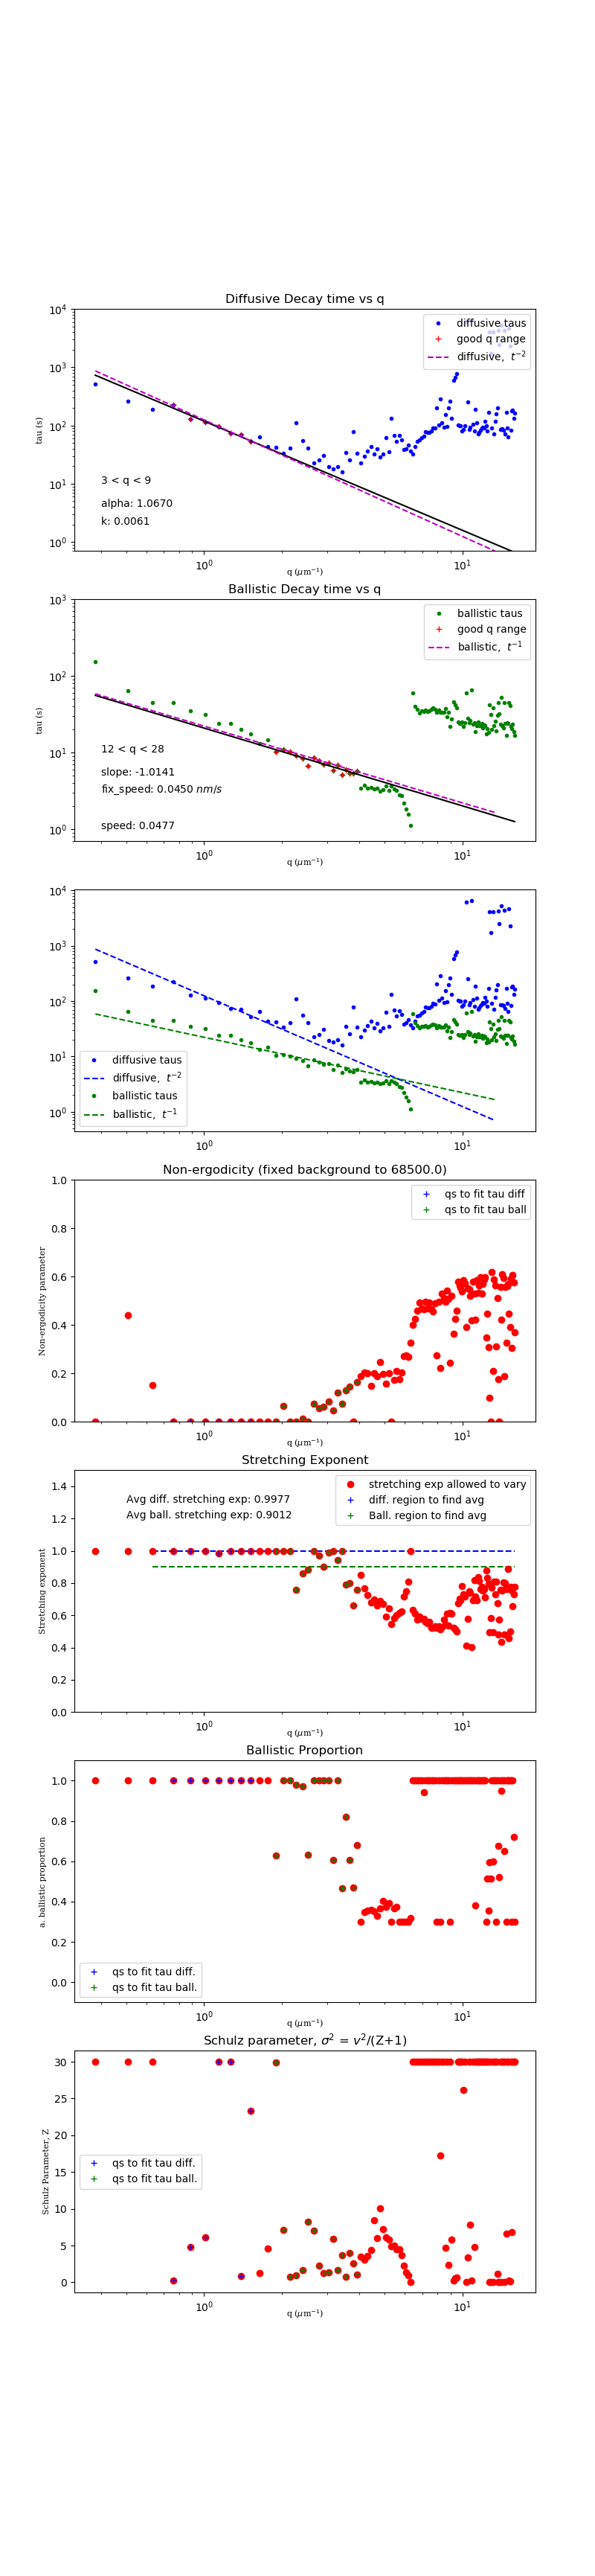

Saved to Y:\Jon_Garamella\data\active_networks\videos_date\2020-07-29\Actin_myosin\ddm_analysis\405stim\20200729_Actin_0237myosin_STIM405_488OD6_50msEXPO_20fps_1_256_256_tauvsq_nonergparam.png


In [238]:
fig = plt.figure(figsize=(8,7*8/1.618)); ax = fig.gca();


qs=q[3:-1]
new_tau_diff=ddm.newt(tau_diff[2:-1],alph_v2[2:-1])
new_tau_ball=ddm.newt(tau_ball[2:-1],alph_v2[2:-1])
######################################################
#Plot the diffusive decay time versus the wave vector#
######################################################

ax = plt.subplot(7,1,1)
plt.title("Diffusive Decay time vs q")
ax.loglog(qs, new_tau_diff,'b.', label='diffusive taus')
#############################################################################
# Pick the range of q-value that seem to fit best (usually ~25ish to ~42ish)
#############################################################################

minqd=3
maxqd=9
qmin=qs[minqd]
qmax=qs[maxqd]
bd = np.where((qs>=qmin)&(qs<=qmax))

ax.plot(qs[bd],new_tau_diff[bd],'r+',label='good q range')
a = np.polyfit(np.log(qs[bd]),np.log(new_tau_diff[bd]), 1)
slope_d = a[0]
coef1_d = np.exp(a[1])
alpha_d = 2./(-1*slope_d)
Dif_d = (1.0/coef1_d)**alpha_d
tau_fit = coef1_d*(qs**(-2.0/alpha_d))
#speed = (1.0/coef1)
ax.plot(qs, tau_fit, '-k')

## does it fit some other power?
fix_speed= .008
fix_slope = 2.
ax.plot(qs[:-20], (1./fix_speed) * (1./(qs[:-20]**(fix_slope))), '--m', label="diffusive, $\ t$$^{-2}$")

#print("'slope' of tau vs q is %.2f" % slope)
#print("'speed' of tau vs q is %.4f" % speed)
ax.text(0.4,4, "alpha: %.4f" % alpha_d)
ax.text(0.4,2, "k: %.4f" % Dif_d)
ax.text(0.4,10, "%i < q < %i" % (minqd, maxqd))
#ax.text(0.9,2, "slope: %.4f" % (slope))
#ax.text(0.4,1, "speed: %.4f" % (speed))
#ax.text(0.9,1, "fix_speed: %.4f" % (fix_speed))
ax.set_xlabel("q ($\mu$m$^{-1}$)", fontdict=font_plt_ax, labelpad=-5)
ax.set_ylabel("tau (s)", fontdict=font_plt_ax)
ax.set_ylim(0.7,10000)
#ax.set_xlim(0.3,1000)
ax.legend(loc=1)

######################################################
#Plot the ballistic decay time versus the wave vector#
######################################################
ax = plt.subplot(7,1,2)
plt.title("Ballistic Decay time vs q")
minqb=12
maxqb=28
qmin=qs[minqb]
qmax=qs[maxqb]
bb = np.where((qs>=qmin)&(qs<=qmax))
ax.loglog(qs, new_tau_ball,'g.', label='ballistic taus')
#ax.loglog(qs, tau_ball_varyalpha[2:-1],'gs',alpha=0.3, label='allowing str exp to vary')

ax.plot(qs[bb],new_tau_ball[bb],'r+',label='good q range')
a = np.polyfit(np.log(qs[bb]),np.log(new_tau_ball[b[0]]), 1)
slope_b = a[0]
coef1_b = np.exp(a[1])
alpha_b = 2./(-1*slope_b)
speed = (1.0/coef1_b)
#Dif = (1.0/coef1)**alpha
tau_fit = coef1_b*(qs**(-2.0/alpha_b))
ax.plot(qs, tau_fit, '-k')

## does it fit some other power?
fix_speed= .045
fix_slope = 1.0
ax.plot(qs[:-20], (1./fix_speed) * (1./(qs[:-20]**(fix_slope))), '--m', label="ballistic, $\ t$$^{-1}$")
ax.set_ylim(0.7,1e3)
#ax.set_xlim(0.3,1000)
ax.legend(loc=1)

#ax.text(0.4,4, "alpha: %.4f" % alpha)
#ax.text(0.4,2, "k: %.4f" % Dif)
ax.text(0.4,10, "%i < q < %i" % (minqb, maxqb))
ax.text(0.4,5, "slope: %.4f" % (slope_b))
ax.text(0.4,1, "speed: %.4f" % (speed))
ax.text(0.4,3, "fix_speed: %.4f $nm/s$" % (fix_speed))
ax.set_xlabel("q ($\mu$m$^{-1}$)", fontdict=font_plt_ax, labelpad=-5)
ax.set_ylabel("tau (s)", fontdict=font_plt_ax)
ax.set_xlabel("q ($\mu$m$^{-1}$)", fontdict=font_plt_ax, labelpad=-5)
ax.set_ylabel("tau (s)", fontdict=font_plt_ax)



######################################################
#######Plot both decay times versus wave vector#######
######################################################
ax = plt.subplot(7,1,3)
ax.loglog(qs, new_tau_diff,'b.', label='diffusive taus')
fix_speed= .008
fix_slope = 2.
ax.plot(qs[:-20], (1./fix_speed) * (1./(qs[:-20]**(fix_slope))), '--b', label="diffusive, $\ t$$^{-2}$")

ax.loglog(qs, new_tau_ball,'g.', label='ballistic taus')
fix_speed= .045
fix_slope = 1.0
ax.plot(qs[:-20], (1./fix_speed) * (1./(qs[:-20]**(fix_slope))), '--g', label="ballistic, $\ t$$^{-1}$")
ax.legend()

#Plot the non-erg parameter versus the wave vector
ax = plt.subplot(7,1,4)
plt.title("Non-ergodicity (fixed background to %.1f)" % background)
ax.semilogx(q[3:-1], c[2:-1], 'ro')

ax.semilogx(qs[bd], c[2:-1][bd], 'b+',label='qs to fit tau diff')

ax.semilogx(qs[bb], c[2:-1][bb], 'g+',label='qs to fit tau ball')

ax.set_ylim(0,1)
ax.set_xlabel("q ($\mu$m$^{-1}$)", fontdict=font_plt_ax, labelpad=-5)
ax.set_ylabel("Non-ergodicity parameter", fontdict=font_plt_ax)
ax.legend(loc=0)


#####################################################
#Plot the stretching exponent versus the wave vector#
#####################################################
ax = plt.subplot(7,1,5)
plt.title("Stretching Exponent")
ax.semilogx(q[3:-1], alph_v2[2:-1], 'ro',label='stretching exp allowed to vary')
##Average Stretching Exponent of the region with diffusive tau fit
ax.plot(qs[bd],alph_v2[2:-1][bd],'b+',label='diff. region to find avg')
ax.hlines(alph_v2[2:-1][bd].mean(), qs[2],qs[-1], linestyles='dashed',colors="b")
ax.text(0.5,1.3,"Avg diff. stretching exp: %.4f" % alph_v2[2:-1][bd].mean())

##Average Stretching Exponent of the region with ballistic tau fit
ax.plot(qs[bb],alph_v2[2:-1][bb],'g+',label='Ball. region to find avg')
ax.hlines(alph_v2[2:-1][bb].mean(), qs[2],qs[-1], linestyles='dashed', colors="g")
ax.text(0.5,1.2,"Avg ball. stretching exp: %.4f" % alph_v2[2:-1][bb].mean())

ax.set_ylim(0,1.5)
ax.set_xlabel("q ($\mu$m$^{-1}$)", fontdict=font_plt_ax, labelpad=-5)
ax.set_ylabel("Stretching exponent", fontdict=font_plt_ax)
ax.legend(loc=1)

##########################################################
#Plot the proportion of population versus the wave vector#
##########################################################
ax = plt.subplot(7,1,6)
plt.title("Ballistic Proportion")
ax.semilogx(q[3:-1], a_pop[2:-1], 'ro',label=None)
ax.plot(qs[bd],a_pop[2:-1][bd],'b+',label='qs to fit tau diff.')
ax.plot(qs[bb],a_pop[2:-1][bb],'g+',label='qs to fit tau ball.')

ax.set_ylim(-.1,1.1)
ax.set_xlabel("q ($\mu$m$^{-1}$)", fontdict=font_plt_ax, labelpad=-5)
ax.set_ylabel("a. ballistic proportion", fontdict=font_plt_ax)
ax.legend(loc=0)

###########################################
#Plot the schulz parameter vs wave vector#
###########################################
ax = plt.subplot(7,1,7)
plt.title("Schulz parameter, $\sigma$$^{2}$ = $v$$^{2}$/(Z+1)")
ax.semilogx(q[3:-1], z_s[2:-1], 'ro',label=None)
ax.plot(qs[bd],z_s[2:-1][bd],'b+',label='qs to fit tau diff.')
ax.plot(qs[bb],z_s[2:-1][bb],'g+',label='qs to fit tau ball.')
#ax.set_ylim(-.1,1.1)
ax.set_xlabel("q ($\mu$m$^{-1}$)", fontdict=font_plt_ax, labelpad=-5)
ax.set_ylabel("Schulz Parameter, Z", fontdict=font_plt_ax)
ax.legend(loc=0)


#Save this figure at a PNG file.
plt.savefig(data_dir+data_file[:-23]+"_tauvsq_nonergparam.png",dpi=150)
print("Saved to %s" % data_dir+data_file[:-23]+"_tauvsq_nonergparam.png")

## IMPORTANT!

After looking at the plots above, figure out a good value for the stretching exponent (what we call 'alpha' in the code). It should be the average stretching exponent over a range of q values. The range of q values in use is indicated with the red or blue crosses on the plot of the decay time vs q and stretching exponent vs q. If that range seems inappropriate, change the `minq` and `maxq` parameters.

Once you've found that, go back to the fitting function -- the `isf_fitting` function -- was defined, and find the first line of that block of code: <br />
`STRETCHING_EXP = 0.6`. <br />
(Or, it might not say '0.6' but some other number.) <br />
Change that value from whatever is to the new value (probably something between 0.3 and 1.0 though it could range anywhere between 0 and 1) and you only need to go to the hundredths place -- no need to go to further decimal places.

## Make sure your datafile is correct for saving

In [168]:
print data_file

20200729_Actin_0237myosin_STIM405_488OD6_50msEXPO_20fps_1_256_256X256_imageffts_for_AB.p


In [232]:
fitting_parameters = {} #initialize empty dictionary
fitting_parameters['last_time'] = last_time
fitting_parameters['qs'] = q
fitting_parameters['qb_used'] = [minqb,maxqb]
fitting_parameters['qd_used'] = [minqd,maxqd]
fitting_parameters['c'] = c 
fitting_parameters['tau_diff'] = new_tau_diff
fitting_parameters['tau_ball'] = new_tau_ball
fitting_parameters['stretching_exponent'] = alph_v2
fitting_parameters['a_ballistic_prop'] = a_pop
fitting_parameters['schulz'] = z_s
fitting_parameters['fps'] = fps
fitting_parameters['pixel_size'] = pixel_size
fitting_parameters['data_directory'] = data_dir
fitting_parameters['Movie'] = movie_num
fitting_parameters['ROI'] = ROI
fitting_parameters['ISF'] = isf
fitting_parameters['times'] = times
fitting_parameters['background'] = background
fitting_parameters['ravs'] = ravs

data_file_p = data_file[:-18]+"_NormalizedISFFitting.p"
f = open(data_dir + data_file_p,'wb')
pickle.dump(fitting_parameters, f)
f.close()

In [243]:
#write some data to more readable file
csv_data_file = condition+"_"+date+"_%i_ROI_%i_256x256_parameters.csv" % (movie_num, ROI)
f = open(data_dir + csv_data_file,'wb')
filewriter = csv.writer(f, delimiter=',')
filewriter.writerow([data_dir])
filewriter.writerow(['date','Movie','ROI','k','alpha','avg stretching exp diff',
                     'slope','speed','fixed ballistic speed','avg stretching exp ball'])
filewriter.writerow([str(date),str(movie_num), str(ROI), "%.4f" % Dif_d, "%.4f" % alpha_d, "%.4f" % alph_v2[2:-1][bd].mean(), 
                    "%.4f" % slope_b, "%.4f" % speed,"%.4f" % fix_speed,"%.4f" % alph_v2[2:-1][bb].mean()])
f.close()

print("Saving to a csv file that you can open with Excel \n")

Saving to a csv file that you can open with Excel 



# At this point, run a new movie or ROI. If you're finished, copy the data from that excel file to the google doc!!!!

## After analyzing all four ROIs of a movie, combine data.

In [235]:
## If you want to combine these files from some other data directory, you can edit data_dir. Otherwise don't.
print("Current 'data_dir' is %s" % data_dir)

Current 'data_dir' is D:\Data\Sylas\2019-2020 XL Bead Analysis\20_1_16_BothXL\DDM\analysis\


In [752]:
#changing data_dir
#data_dir = "D:\\Data\\Sylas\\2019-2020 XL Bead Analysis\\20_1_14_CoXL\\analysis\\"

In [236]:
csv_files = glob.glob(data_dir + "*_%i_ROI*.csv" % movie_num)

csv_all_data_file = condition+"_%i_all_256x256_parameters.csv" % movie_num
f_all = open(data_dir + csv_all_data_file,'wb')
filewriter = csv.writer(f_all, delimiter=',')
f_all_header_not_written_yet = True

for i,filename in enumerate(csv_files):
    if not "_all_" in filename:
        f = open(filename,'r')
        filereader = csv.reader(f, delimiter=',')
        for j,row in enumerate(filereader):
            if f_all_header_not_written_yet:
                filewriter.writerow(row)
            else:
                if j>1:
                    filewriter.writerow(row)
        f_all_header_not_written_yet = False
        f.close()
f_all.close()